In [10]:
import numpy as np
import matplotlib.pyplot as plt

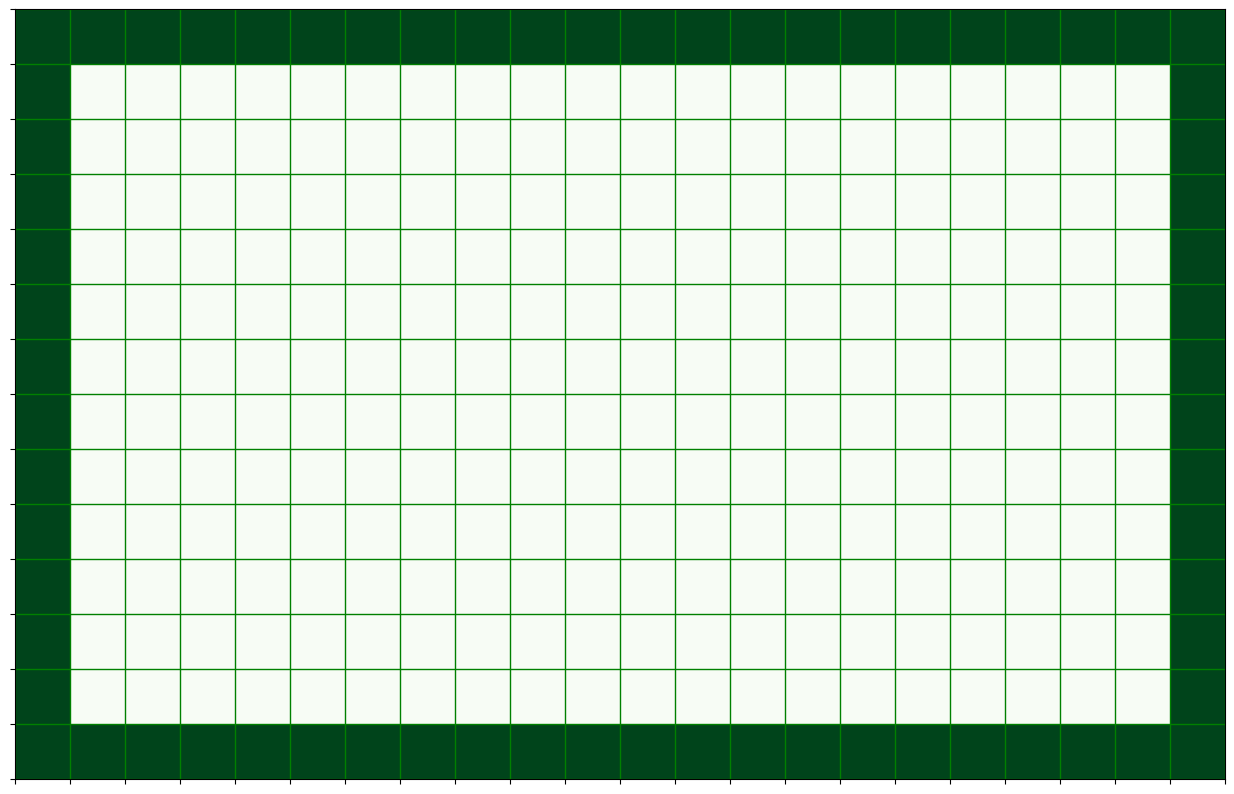

In [11]:
def display_grid(width, height):
    grid = np.zeros((height, width), dtype=int)
    grid[0, :] = grid[:, 0] = grid[-1, :] = grid[:, -1] = 2

    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(grid, cmap='Greens')
    ax.set_xticks(np.arange(-0.5, width, 1))
    ax.set_yticks(np.arange(-0.5, height, 1))
    ax.grid(color='green', linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

# Usage example
display_grid(22, 14)


In [12]:
def knapSack(W, wt, val, n):
    K = [[0 for w in range(W + 1)]
            for i in range(n + 1)]
             
    # Build table K[][] in bottom up manner
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i - 1] <= w:
                K[i][w] = max(val[i - 1] 
                  + K[i - 1][w - wt[i - 1]],
                               K[i - 1][w])
            else:
                K[i][w] = K[i - 1][w]
 
    return K[n][W]
 

# Driver code
val = [60, 100, 120]
wt = [10, 20, 30]
W = 50
n = len(val)
 
print(knapSack(W, wt, val, n))

220


In [13]:
matrix = [
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
]

In [17]:
import numpy as np

def is_rectangular(region):
    rows, cols = zip(*region)
    return min(rows) <= max(rows) and min(cols) <= max(cols)

def region_size(grid, row, col):
    visited = np.full(grid.shape, False, dtype=bool)
    stack = [(row, col)]
    size = 0

    while stack:
        r, c = stack.pop()
        if (0 <= r < grid.shape[0] and 0 <= c < grid.shape[1] and
                not visited[r][c] and grid[r][c] != -1):
            visited[r][c] = True
            size += 1
            stack.extend([(r-1, c), (r+1, c), (r, c-1), (r, c+1)])  # up, down, left, right

    return size

def find_regions(grid, value):
    visited = np.full(grid.shape, False, dtype=bool)
    regions = []
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if grid[r][c] == value and not visited[r][c]:
                stack = [(r, c)]
                region = []
                while stack:
                    curr_r, curr_c = stack.pop()
                    if (0 <= curr_r < grid.shape[0] and 0 <= curr_c < grid.shape[1] and
                            not visited[curr_r][curr_c] and grid[curr_r][curr_c] == value):
                        visited[curr_r][curr_c] = True
                        region.append((curr_r, curr_c))
                        stack.extend([(curr_r-1, curr_c), (curr_r+1, curr_c), (curr_r, curr_c-1), (curr_r, curr_c+1)])  # up, down, left, right
                regions.append(region)
    return regions

def is_valid(grid, matrix):
    for r in range(grid.shape[0]):
        for c in range(grid.shape[1]):
            if matrix[r][c] != 0 and matrix[r][c] != region_size(grid, r, c):
                return False

    shaded_regions = find_regions(grid, 1)
    unshaded_regions = find_regions(grid, 0)

    if any(is_rectangular(region) for region in unshaded_regions):
        return False

    if not all(is_rectangular(region) for region in shaded_regions):
        return False

    return True

def solve(grid, matrix, row, col):
    if row == grid.shape[0]:
        return grid if is_valid(grid, matrix) else None

    next_row, next_col = (row, col + 1) if col != grid.shape[1] - 1 else (row + 1, 0)

    for cell_state in [0, 1]:  # 0 for unshaded, 1 for shaded
        grid[row][col] = cell_state
        if is_valid(grid, matrix):
            result = solve(grid, next_row, next_col)
            if result is not None:  # A valid grid was found
                return result
        grid[row][col] = -1  # Reset cell

    return None  # No valid grid found from this point


In [18]:
matrix = np.array([
    [0,6,0,0,0,0,0],
    [0,0,0,0,0,0,3],
    [0,0,0,3,0,0,0],
    [0,0,6,1,5,0,0],
    [0,0,0,4,0,0,0],
    [5,0,0,0,0,0,0],
    [0,0,0,0,0,4,0]
])

# Create an empty grid with -1 indicating unfilled cells
grid = np.full(matrix.shape, -1, dtype=int)

solution = solve(grid, matrix, 0, 0)

if solution is not None:
    print("Solution found:")
    print(solution)
else:
    print("No solution found.")


No solution found.
